*Ответ: NET Profit 0.5832** (код в разделе II. Основной код)
    
С учётом начального капитала Profit = 1.5832
    

Стратегия:

В каждый момент времени есть кандидат на покупку/продажу (это есть некоторый ценовой уровень). Далее определяем оптимальный это кандидат или нет.

1. Возникает тригер на продажу, думаем - а вдруг это не лучший момент, идём смотреть дальше.

В тот момент когда решили продать делаем пометку, что мы готовы здесь продавать,
но смотрим массив дальше, а дальше нужно следить за линией бидов и асков:

если линия асков раньше пересечётся с уровнем, на котором хочу продать - то продаём там, где был триггер,
а если линия бидов возвращается к этому уровню раньше, чем линия асков, то держим дальше (ничего не делаем).

2. Дальше мы не в позиции и надо найти лучший момент для входа.

Лучший момент для входа будет на локальном минимуме асков,
но там ситуация меняется  - логика линии бидов и асков меняется местами: если линия бидов пересекает раньше, то закупаемся (входим),
если линия асков раньше, то держим позицию.

**I. Анализ данных**

In [297]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_json('raw.chartblock.json', orient='values')
bids = df.ticks[0]
asks = df.ticks[1]

bids = np.array(bids)
asks = np.array(asks)

bids = bids[:, 1]
asks = asks[:, 1]

bids.shape, asks.shape

((39973,), (39973,))

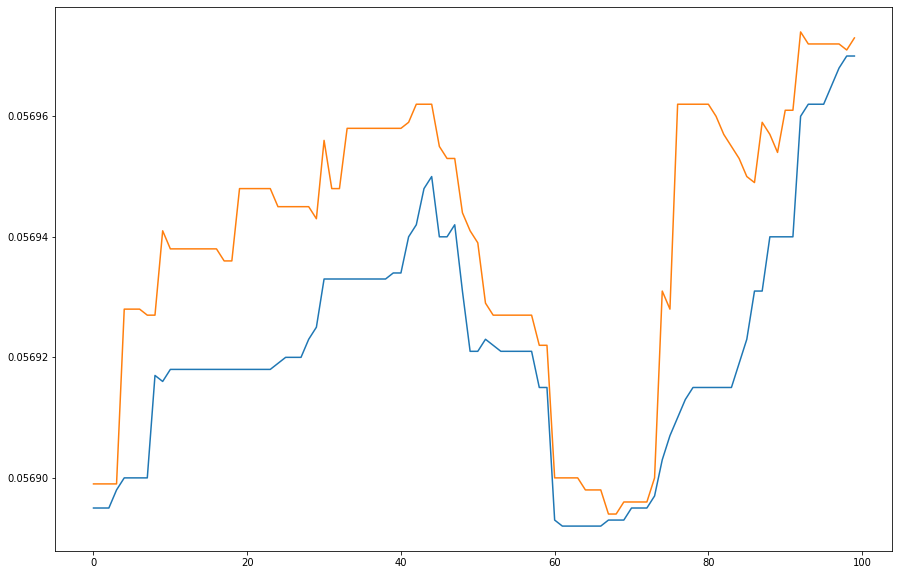

In [298]:
plt.figure(figsize=(15, 10))
plt.plot(bids[250:350])
plt.plot(asks[250:350])

Дан временной ряд c best bid-ask ценами в $, который был получен из будущего. 
Мы можем покупать и продавать по указанным ценам только целое количество актива. 
Отрицательные позиции не разрешены.

В предположении, что рынок идеально ликвидный (нет проскальзывания цены, нет price impact'а), 
а исполнение заявок происходит моментально, построить идеальную стратегию торговли с учетом знания будущей цены, 
если в начальный момент времени мы располагаем всего 1$. Получить значение итогового профита для этой стратегии. 

Алгоритм решения должен быть однопроходным, линейным по времени и константным по памяти.

По условию 
1) разрешается помнить любые цены из прошлого и будущего, но конечное количество.
Главное условие - память ограничена. Нельзя хранить все предыдущие или последующие цены.
2) в начальный момент времени вам известны все цены в будущем. Но прочитать каждую можно только один раз, это и есть условие однопроходности. 
3) в каждый дискретный момент времени мы можете купить, продать или ничего не делать. Времени «между» не существует в рамках этой модели. 

**II. Основной код**

In [299]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import floor

df = pd.read_json('raw.chartblock.json', orient='values')
bids = df.ticks[0]
asks = df.ticks[1]

bids = np.array(bids)
asks = np.array(asks)

bids = bids[:, 1]
asks = asks[:, 1]



def cross(p1, p2, target):
    # strict cross: p1 is bellow target, p2 is above target or v.v.
    p1 -= target
    p2 -= target
    return p1 * p2 <= 0

account = 1
n_stocks = 0

in_position = False
i = 0
min_ask = asks[0]
max_bid = None

buy_history = []
id = 0
sell_history = []
loc_mins = []
loc_maxs = []
loc_min_ids = []
loc_max_ids = []
acc = [1]
pos = []
posid = []
# m = [0.0575, 0.05745]

while i <= len(asks) - 2:
    
#     pos.append(m[in_position])
    posid.append(i)

    cur_bid = bids[i]
    next_bid = bids[i+1]
    cur_ask = asks[i]
    next_ask = asks[i+1]

    if not in_position:
        cur_bid = bids[i]
        next_bid = bids[i+1]
        cur_ask = asks[i]
        # min_ask = min(min_ask, cur_ask)
        if  cur_ask < min_ask:
            min_ask = cur_ask
            id = i

        if cross(cur_bid, next_bid, min_ask):
            loc_min_ids.append(i)
            loc_mins.append(cur_bid)
            buy_history += [(id, min_ask)]
            n_stocks = floor(account / min_ask)
            account -= n_stocks * min_ask
            in_position = True
            max_bid = next_bid
            id = i + 1
    else:
        # max_bid = max(max_bid, cur_bid)
        if  cur_bid >= min_ask and cur_bid > max_bid:
            max_bid = cur_bid
            id = i
        # print(f'({i}) max_bid = {max_bid}, cur_bid = {cur_bid}, cur_ask={cur_ask}, next_ask={next_ask}')
        if max_bid >= min_ask and cross(cur_ask, next_ask, max_bid):
            loc_max_ids.append(i)
            loc_maxs.append(cur_ask)
            sell_history += [(id, max_bid)]
            account += n_stocks * max_bid
            acc.append(account)
            n_stocks = 0
            in_position = False
            min_ask = next_ask
            id = i + 1
    i += 1

if n_stocks != 0:
    loc_max_ids.append(i)
    loc_maxs.append(asks[i])
    sell_history += [(id, max_bid)]
    account += n_stocks * max_bid
    acc.append(account)
    n_stocks = 0

print(account)
print('NET profit {0:.4f}'.format(account-1))

1.5832
NET profit 0.5832


**III. Графики**

In [300]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import floor

df = pd.read_json('raw.chartblock.json', orient='values')
bids = df.ticks[0]
asks = df.ticks[1]

bids = np.array(bids)
asks = np.array(asks)

bids = bids[:, 1]
asks = asks[:, 1]



def cross(p1, p2, target):
    # strict cross: p1 is bellow target, p2 is above target or v.v.
    p1 -= target
    p2 -= target
    return p1 * p2 <= 0

account = 1
n_stocks = 0

in_position = False
i = 0
min_ask = asks[0]
max_bid = None

buy_history = []
id = 0
sell_history = []
loc_mins = []
loc_maxs = []
loc_min_ids = []
loc_max_ids = []
acc = [1]
pos = []
posid = []
# m = [0.0575, 0.05745]

while i <= len(asks) - 2:
    
#     pos.append(m[in_position])
    posid.append(i)

    cur_bid = bids[i]
    next_bid = bids[i+1]
    cur_ask = asks[i]
    next_ask = asks[i+1]

    if not in_position:
        cur_bid = bids[i]
        next_bid = bids[i+1]
        cur_ask = asks[i]
        # min_ask = min(min_ask, cur_ask)
        if  cur_ask < min_ask:
            min_ask = cur_ask
            id = i

        if cross(cur_bid, next_bid, min_ask):
            loc_min_ids.append(i)
            loc_mins.append(cur_bid)
            buy_history += [(id, min_ask)]
            n_stocks = floor(account / min_ask)
            account -= n_stocks * min_ask
            in_position = True
            max_bid = next_bid
            id = i + 1
    else:
        # max_bid = max(max_bid, cur_bid)
        if  cur_bid >= min_ask and cur_bid > max_bid:
            max_bid = cur_bid
            id = i
        # print(f'({i}) max_bid = {max_bid}, cur_bid = {cur_bid}, cur_ask={cur_ask}, next_ask={next_ask}')
        if max_bid >= min_ask and cross(cur_ask, next_ask, max_bid):
            loc_max_ids.append(i)
            loc_maxs.append(cur_ask)
            sell_history += [(id, max_bid)]
            account += n_stocks * max_bid
            acc.append(account)
            n_stocks = 0
            in_position = False
            min_ask = next_ask
            id = i + 1
    i += 1

if n_stocks != 0:
    loc_max_ids.append(i)
    loc_maxs.append(asks[i])
    sell_history += [(id, max_bid)]
    account += n_stocks * max_bid
    acc.append(account)
    n_stocks = 0

print(account)
print('NET profit {0:.4f}'.format(account-1))

1.5832
NET profit 0.5832


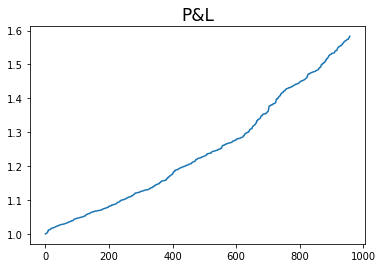

In [301]:
plt.title('P&L', fontsize=17)
plt.plot(acc)

Далее на графиках: начало красной линии - закупились, конец - продались

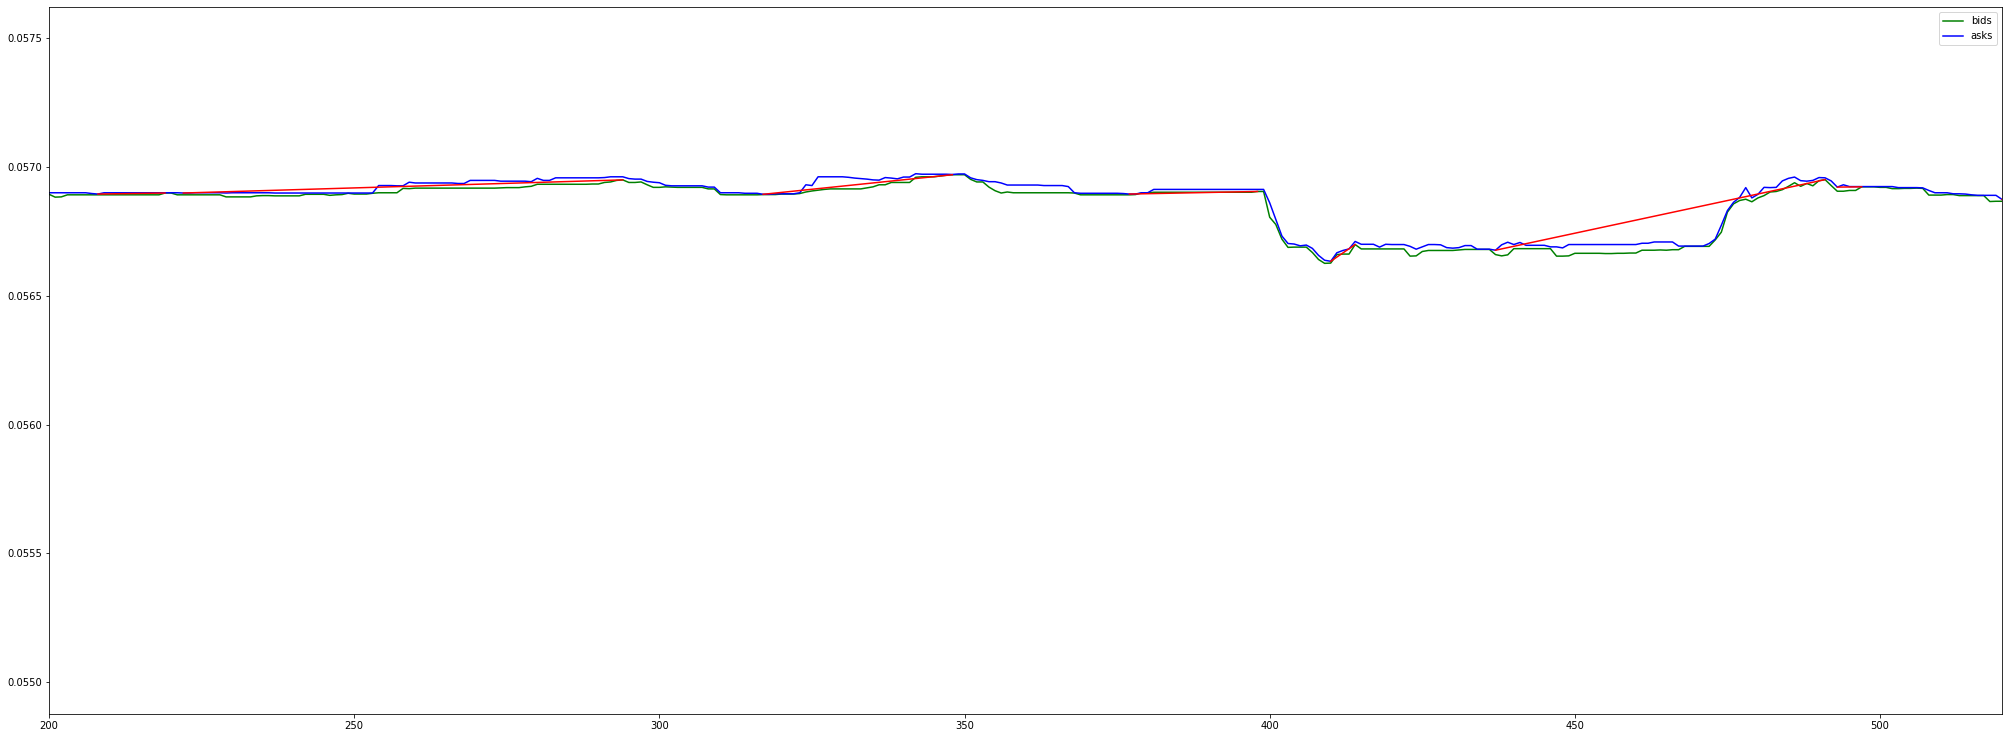

In [307]:
plt.figure(figsize=(35, 13))
plt.plot( bids, color='green', label='bids')
plt.plot( asks, color='blue', label='asks')
#plt.scatter(posid, pos, color='purple', marker='.')

for i in range(len(buy_history)):
    i1, p1 = buy_history[i]
    i2, p2 = sell_history[i]
    plt.plot([i1, i2], [p1, p2], color='r')
    


plt.xlim([200,520])
plt.legend();

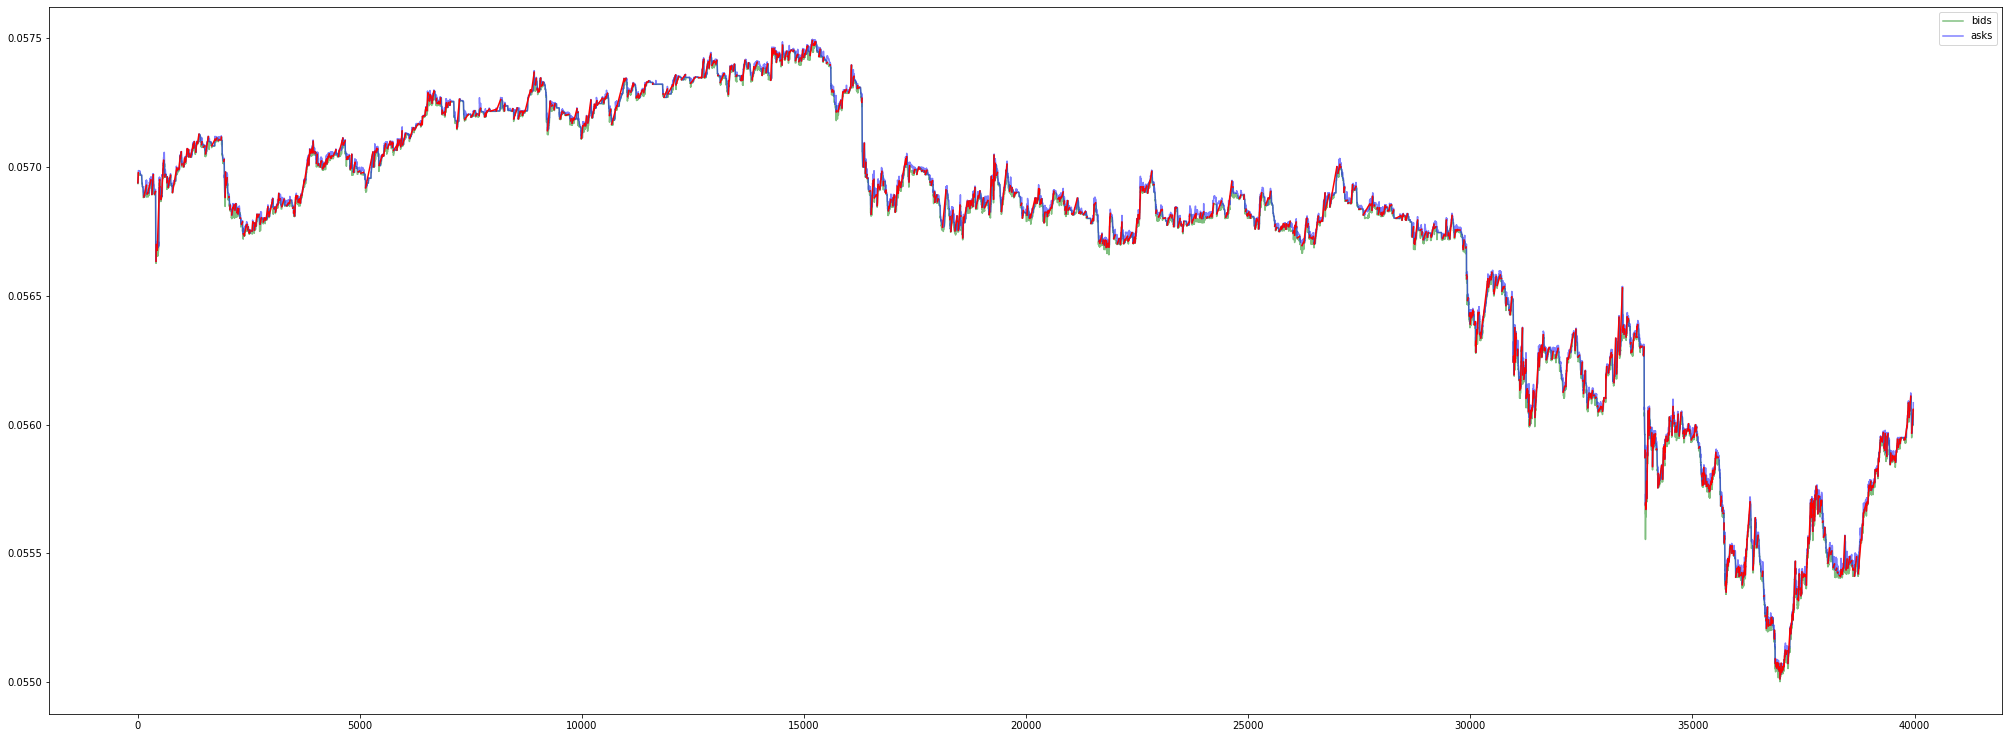

In [308]:
plt.figure(figsize=(35, 13))
plt.plot( bids, color='green', label='bids', alpha=0.5)
plt.plot( asks, color='blue', label='asks', alpha=0.5)
# plt.scatter(posid, pos, color='purple', marker='.')

for i in range(len(buy_history)):
    i1, p1 = buy_history[i]
    i2, p2 = sell_history[i]
    plt.plot([i1, i2], [p1, p2], color='r')
    


# plt.xlim([200,520])
plt.legend();

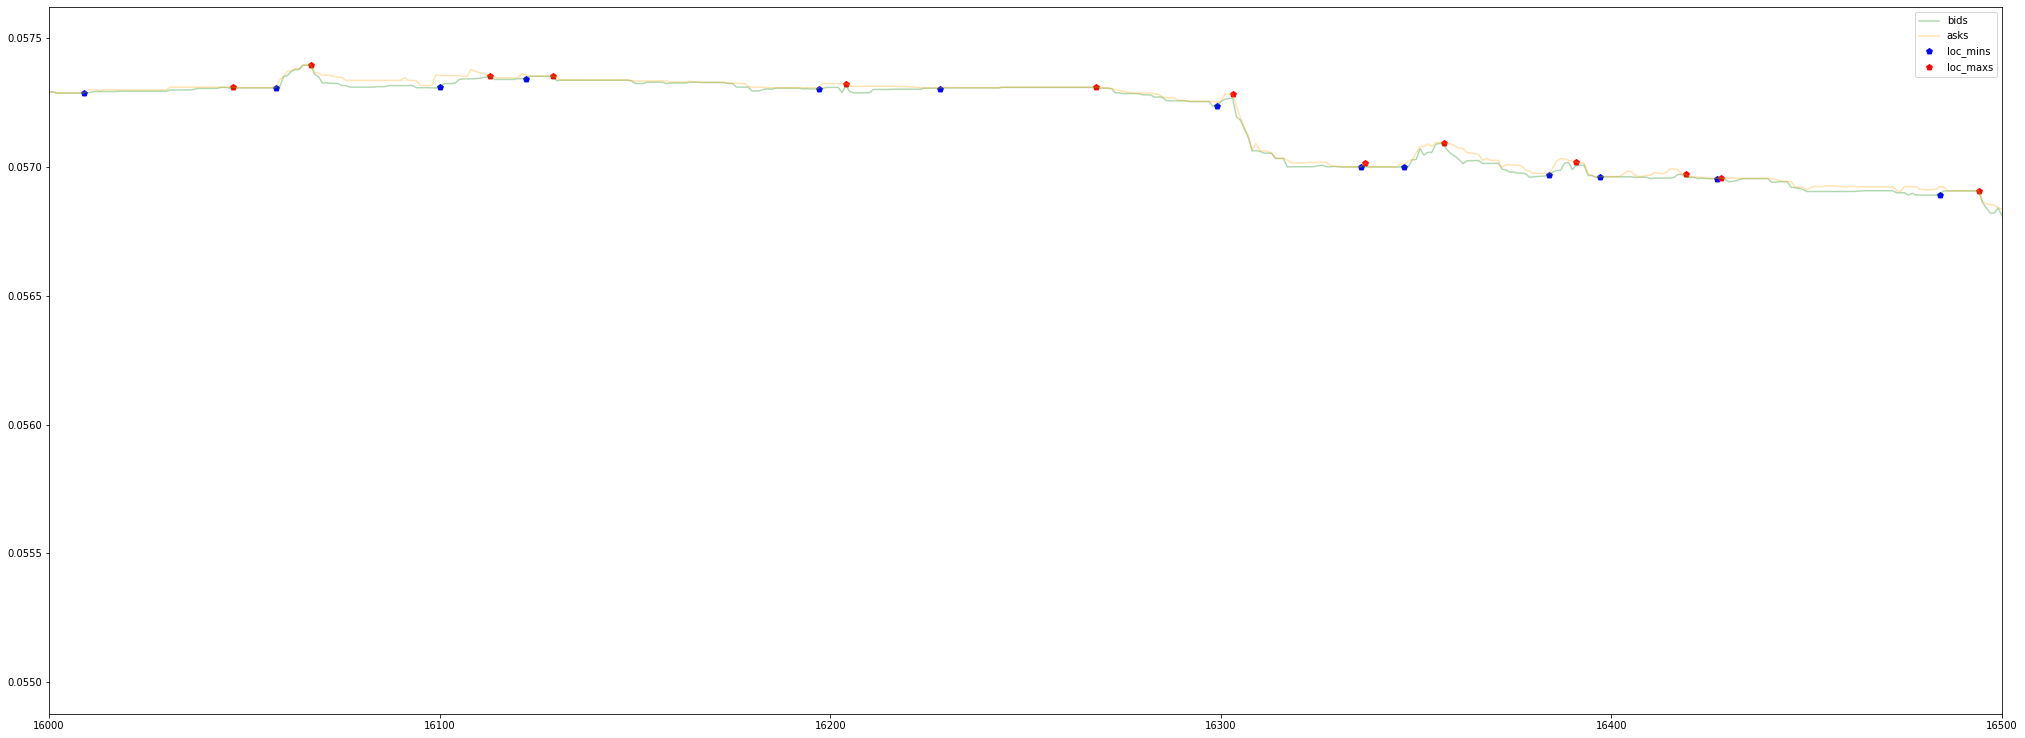

In [309]:
plt.figure(figsize=(35, 13))
plt.plot( bids, color='green', label='bids', alpha=0.3)
plt.plot( asks, color='orange', label='asks', alpha=0.3)

plt.scatter(loc_min_ids, loc_mins, label='loc_mins', marker='p', color='blue')
plt.scatter(loc_max_ids, loc_maxs, label='loc_maxs', marker='p', color='red')

plt.xlim([16000, 16500])
plt.legend()

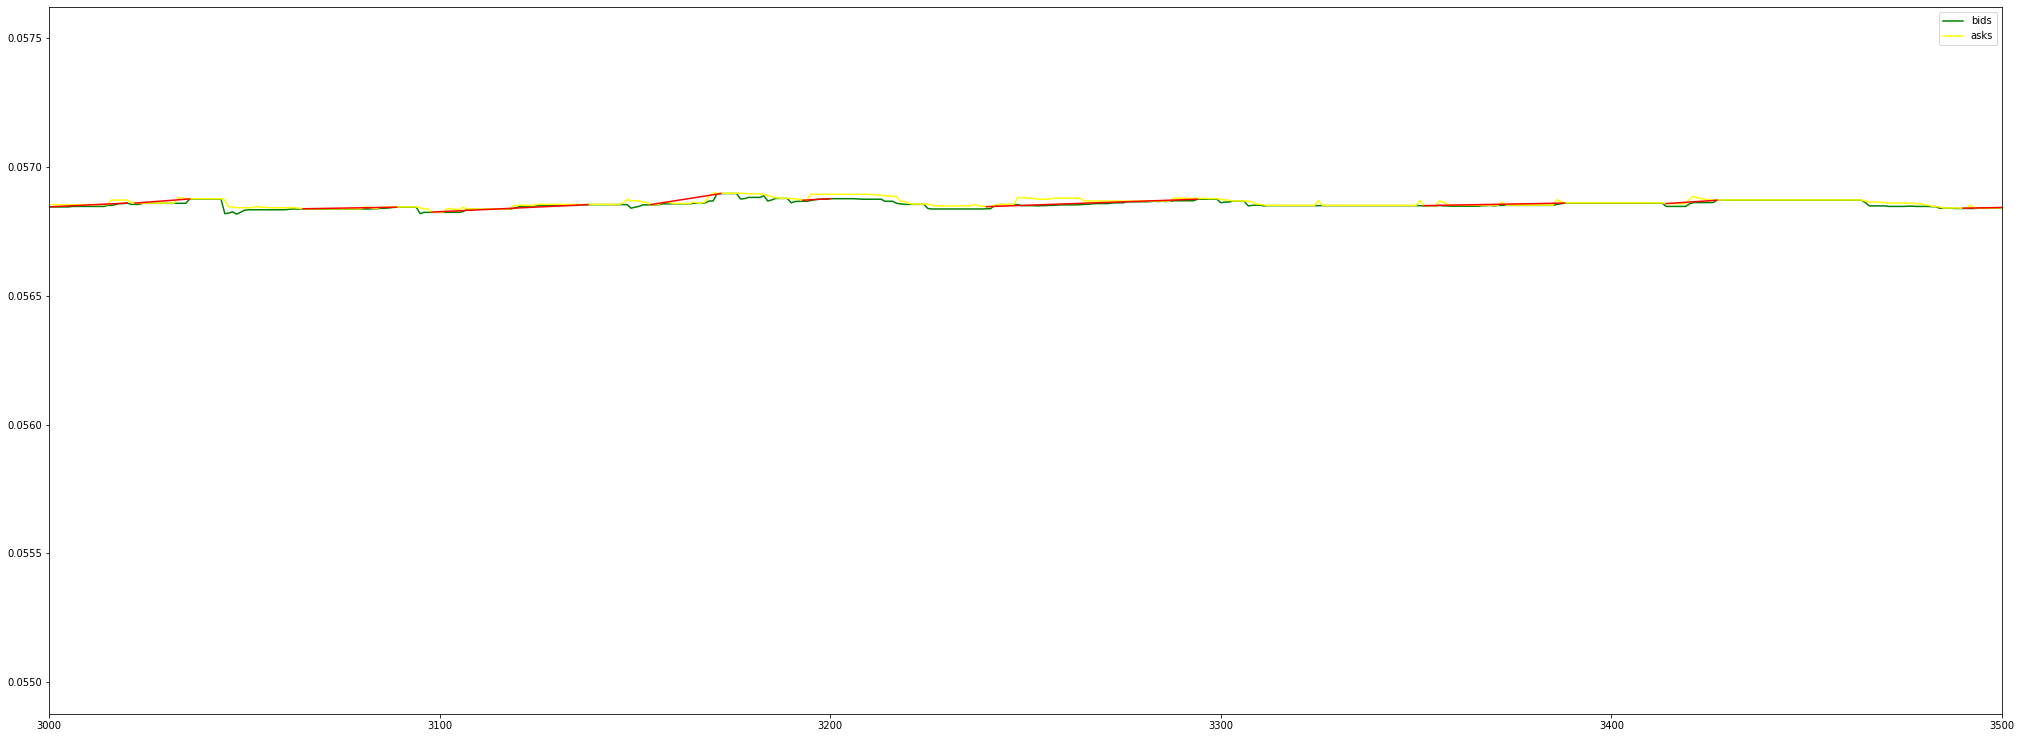

In [310]:
plt.figure(figsize=(35, 13))
plt.plot( bids, color='green', label='bids')
plt.plot( asks, color='yellow', label='asks')

for i in range(len(buy_history)):
    i1, p1 = buy_history[i]
    i2, p2 = sell_history[i]
    plt.plot([i1, i2], [p1, p2], color='r')


plt.xlim([3000, 3500])
plt.legend();

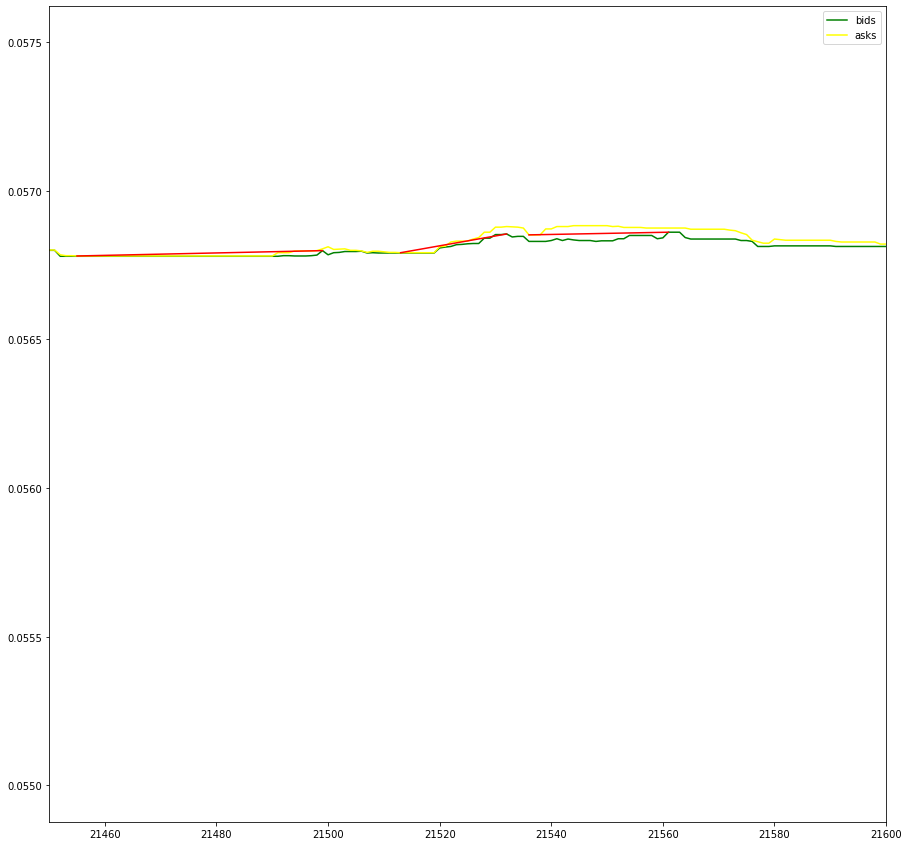

In [311]:
plt.figure(figsize=(15, 15))
plt.plot( bids, color='green', label='bids')
plt.plot( asks, color='yellow', label='asks')

for i in range(len(buy_history)):
    i1, p1 = buy_history[i]
    i2, p2 = sell_history[i]
    plt.plot([i1, i2], [p1, p2], color='r')


plt.xlim([21450, 21600])
plt.legend();

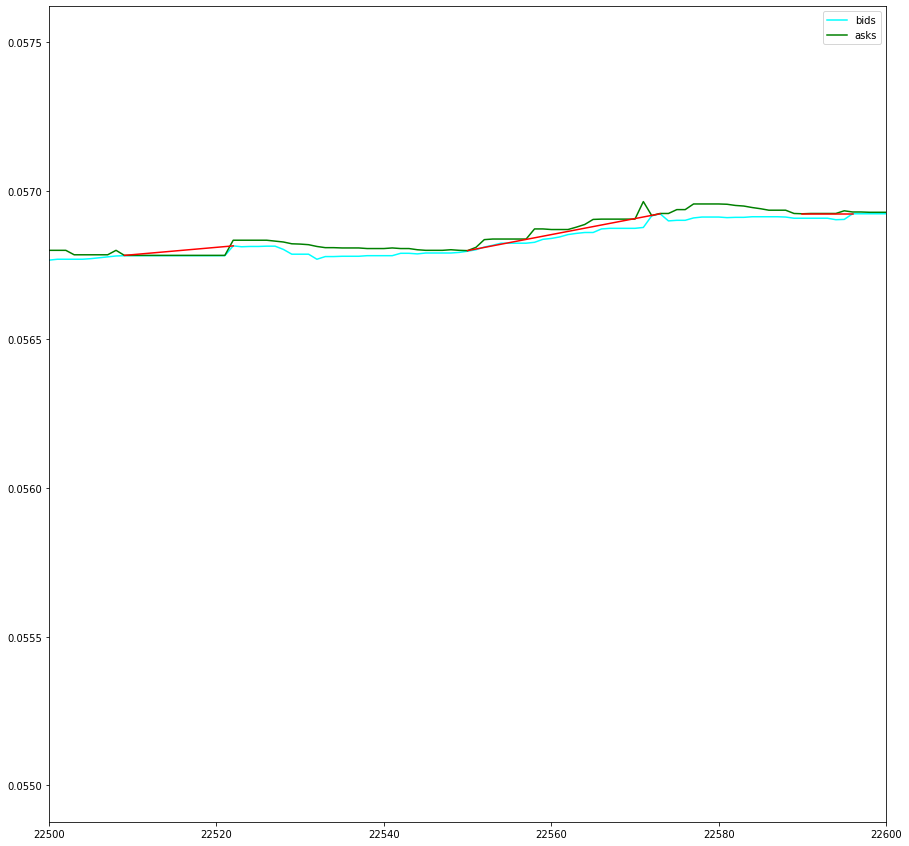

In [312]:
plt.figure(figsize=(15, 15))
plt.plot( bids, color='cyan', label='bids')
plt.plot( asks, color='green', label='asks')

for i in range(len(buy_history)):
    i1, p1 = buy_history[i]
    i2, p2 = sell_history[i]
    plt.plot([i1, i2], [p1, p2], color='r')


plt.xlim([22500, 22600])
plt.legend();

Далее - разные версии поиска оптимальной стратегии 

**Версия 1**

In [295]:
from math import floor

bids = np.array(bids)
asks = np.array(asks)

buy_price = asks[0]
prev_bid = bids[0]  # предыдущий бид - считаем, что в настоящем
moneypig = 1 # наш баланс
right_pos = 1 # индекс, который будем двигаться - отвечает за будущее

while right_pos <= len(asks)-1:
    curr_ask  = asks[right_pos] # начинаем с первой позиции
    curr_bid = bids[right_pos] # будущий бид

    if curr_bid < prev_bid: # контролируем момент спада, и если происходит обвал, то сравниваем 
        if prev_bid > buy_price: # точку последнюю перед обвалом с ценой покупки и если больше, то
            moneypig += floor(moneypig/buy_price)*(prev_bid - buy_price) # проводим транзакцию
            buy_price = curr_ask # сдвигаем левый указатель
        elif prev_bid < buy_price: # если же происходит обвал без роста, то 
            buy_price = curr_ask # просто переносим левый указатель 

    prev_bid = curr_bid
    right_pos += 1

print(moneypig)
print('NET profit {0:.6f}'.format(moneypig-1))

1.3707619999999954
NET profit 0.370762


**Версия 2**

In [296]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import floor

df = pd.read_json('raw.chartblock.json', orient='values')
bids = df.ticks[0]
asks = df.ticks[1]

bids = np.array(bids)
asks = np.array(asks)

bids = bids[:, 1]
asks = asks[:, 1]

# bids = [0.1, 0.15, 0.16, 0.17, 0.19, 0.8, 0.75]
# asks = [0.7, 0.2, 0.3, 0.4, 0.9,  0.95, 0.91]
# bids = [0.1,0.3,0.5,0.7,0.9]
# asks = [0.2,0.4,0.6,0.8,1]


buy_price = asks[0]
prev_bid = bids[0] # предыдущий бид - считаем, что в настоящем
prev_ask = asks[0]
prev_prev_ask = asks[0]
moneypig = 1 # наш баланс
right_pos = 1 # индекс, который будем двигаться - отвечает за будущее

while right_pos <= len(asks)-1:
    curr_ask = asks[right_pos] # начинаем с первой позиции
    curr_bid = bids[right_pos] # будущий бид

    if curr_bid < prev_bid: # контролируем момент спада, и если происходит обвал, то сравниваем
        if prev_bid > buy_price: # точку последнюю перед обвалом с ценой покупки и если больше, то
            moneypig += floor(moneypig/buy_price)*(prev_bid - buy_price) # проводим транзакцию
            buy_price = curr_ask # сдвигаем левый указатель
        elif prev_bid < buy_price: # если же происходит обвал без роста, то 
            buy_price = curr_ask # просто переносим левый указатель

    if right_pos == len(asks)-1:
        if curr_bid > buy_price and buy_price != curr_ask:
            print()
            moneypig += floor(moneypig/buy_price)*(curr_bid - buy_price)
            


    prev_prev_ask = prev_ask
    prev_ask = curr_ask
    buy_price = min(buy_price, prev_prev_ask) # сохраняем минимальную цену покупки на участках роста цены
    prev_bid = curr_bid
    right_pos += 1

print(moneypig)
print('NET profit {0:.4f}'.format(moneypig-1))

1.493497999999997
NET profit 0.4935
